
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [3]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [4]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [5]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [6]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [7]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [8]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [9]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 window
 server
 use
 motif
 using
 program
 widget
 application
 like
 code


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 asking
 new
 interested
 price
 sell


Cluster 2:
 know
 mac
 thanks
 just
 does
 like
 drive
 apple
 don
 new


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 oil




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

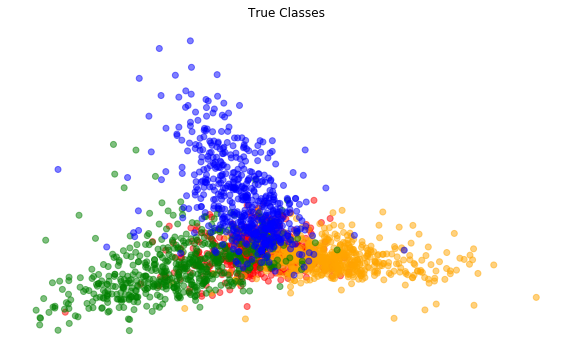

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

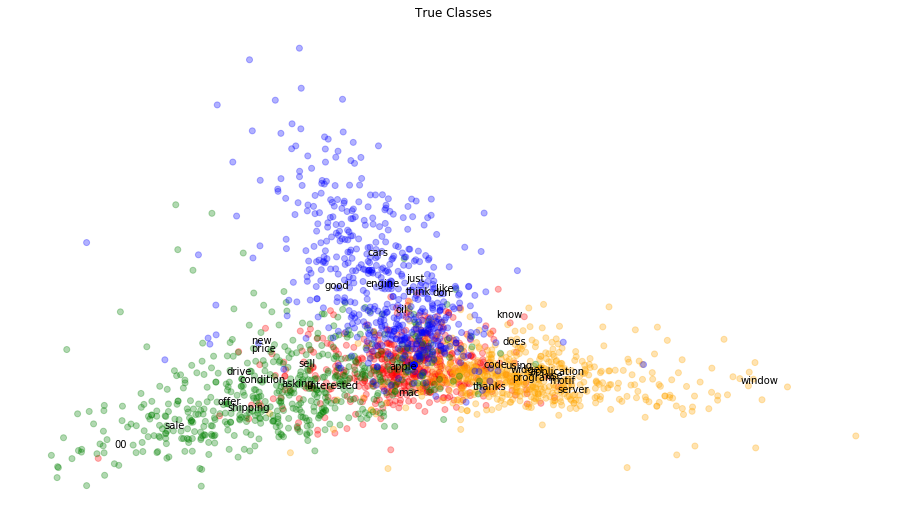

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

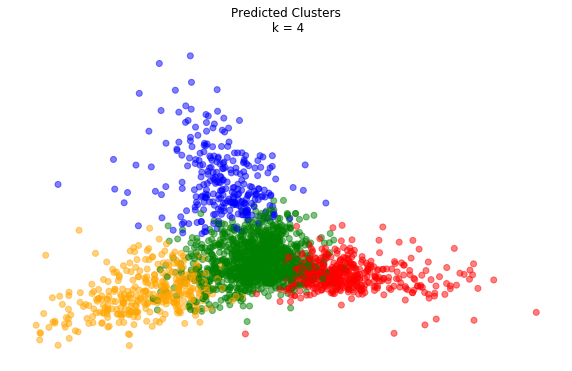

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [29]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


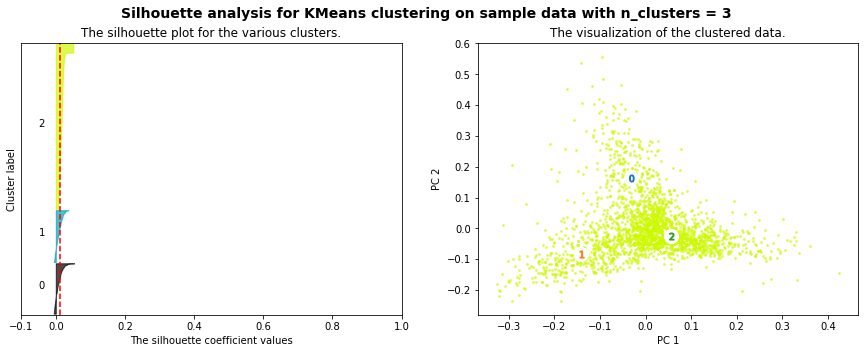

For n_clusters = 3, The average silhouette_score is : 0.013


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


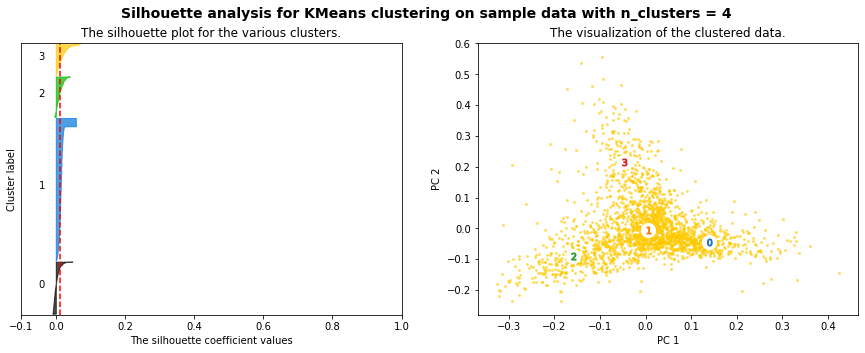

For n_clusters = 4, The average silhouette_score is : 0.012


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


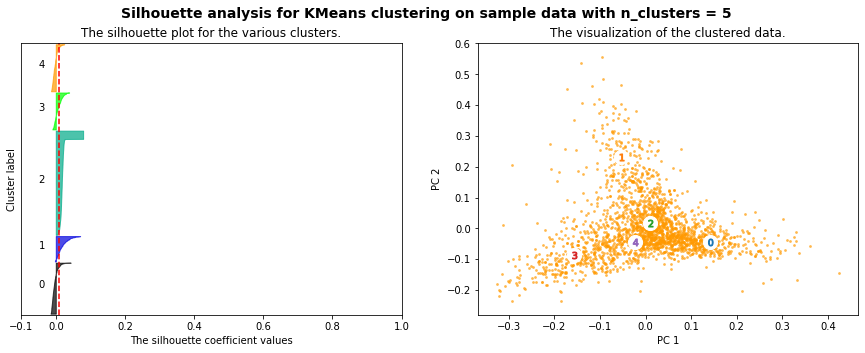

For n_clusters = 5, The average silhouette_score is : 0.010


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


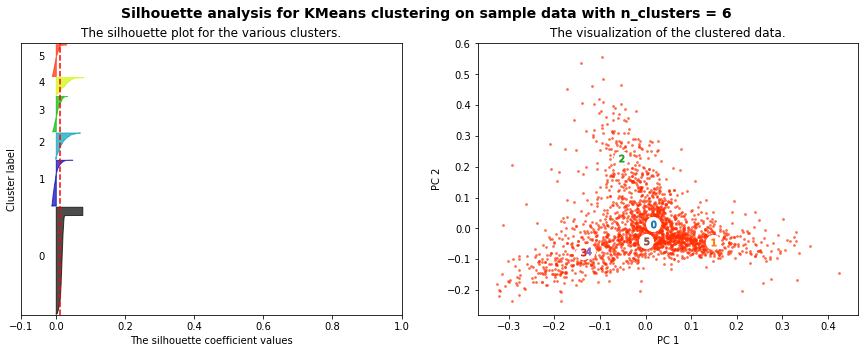

For n_clusters = 6, The average silhouette_score is : 0.011


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [34]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [35]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [36]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [37]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [38]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [39]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [40]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

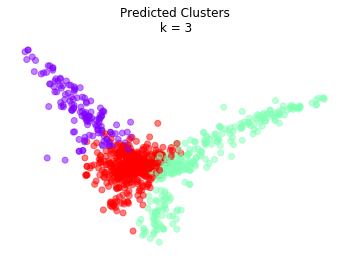

In [41]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [42]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,2
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,2
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [53]:
tweets_df = pandas.read_csv('metoo.csv',encoding='ISO-8859-1') #read a csv of #metoo tweets
tweets_df

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2/13/20 18:25,acslaw,NaN,0,0,0,ACS has formed a #MeToo Task Force to combat s...,NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/acslaw/status/122802248369...
1,2/13/20 18:25,HealingFrTrauma,NaN,0,0,0,"Hey all, you know adult ADHD maybe a result of...",NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/HealingFrTrauma/status/122...
2,2/13/20 18:24,RvnsNest,NaN,0,0,0,"From 1996 to 1997, four women filed sexual-har...",NaN,@megangarber,#MeToo #MeToo,1.230000e+18,https://twitter.com/RvnsNest/status/1228022249...
3,2/13/20 18:23,film_pasco,brujasdelmar,0,0,0,#UNAM #FeminicidioEmergenciaNacional #Feminici...,NaN,NaN,#UNAM #FeminicidioEmergenciaNacional #Feminici...,1.230000e+18,https://twitter.com/film_pasco/status/12280219...
4,2/13/20 18:22,bernieshinder,davidaxelrod,0,0,0,We reacted (or didn_t react at all) to negat...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/bernieshinder/status/12280...
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,2/13/20 8:02,elZenakarGrande,NaN,2,1,63,©Ë_Ë±ÈÛÈ_ËèË_ãï ËË± ©Ë_ È_ãïË_Ë_ _ãï ËÎÈ_ Ëë...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/elZenakarGrande/status/122...
1296,2/13/20 8:02,westcookreview,NaN,0,0,0,FOXX SAYS WEBB PULLED A COMEY _î BERNIE WINS ...,NaN,NaN,#METOO #METOO,1.230000e+18,https://twitter.com/westcookreview/status/1227...
1297,2/13/20 8:02,Sabrina67408695,Josie80360617,0,0,0,#metoo,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/Sabrina67408695/status/122...
1298,2/13/20 8:01,WWRPodcast,NaN,0,3,0,"New Podcast! ""What's up with Harvey Weinstein...",NaN,@spreaker,#billcosby #epstein #freerkelly #ghislainemaxw...,1.230000e+18,https://twitter.com/WWRPodcast/status/12278654...


In [54]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
tweetsgroupsVects = ngCountVectorizer.fit_transform(tweets_df['text'])
print(tweetsgroupsVects.shape)
#time frequency inverse document frequency - tf-idf for tweets
#initialize TF fransformer
tweetsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(tweetsgroupsVects)
#train
tweetsgroupsTF = tweetsgroupsTFTransformer.transform(tweetsgroupsVects)
print(tweetsgroupsTF.shape)
list(zip(ngCountVectorizer.vocabulary_.keys(), tweetsgroupsTF.data))[:10]

(1300, 8352)
(1300, 8352)


[('acs', 0.10847852856516624),
 ('has', 0.11887361565756747),
 ('formed', 0.21894161215580019),
 ('metoo', 0.1310909676219013),
 ('task', 0.12072602231505798),
 ('force', 0.21894161215580019),
 ('to', 0.18226182703852667),
 ('combat', 0.1921134347628654),
 ('sexual', 0.21763403831849729),
 ('harassment', 0.2070699545382207)]

In [55]:
#initialize with the TF vectorizer provided in the examples
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train it on the #MeToo tweets
metooTFVects = exampleTFVectorizer.fit_transform(tweets_df['text'])

tweets_df['text'][:10]

0    ACS has formed a #MeToo Task Force to combat s...
1    Hey all, you know adult ADHD maybe a result of...
2    From 1996 to 1997, four women filed sexual-har...
3    #UNAM #FeminicidioEmergenciaNacional #Feminici...
4    We reacted (or didn_t react at all) to negat...
5    I_d do her is now a #metoo thing? How about ...
6    @Donnarotunno is lawyer goals! Damn, she is so...
7    Uh-Oh. Bloomie might want to reconsider things...
8    Hmmmmmm. Let me guess how many of us liberal g...
9    Which is fine, I_m sure she has her reasons....
Name: text, dtype: object

In [56]:
numCategories = 4  # since my dataset has no formal categories, for this example I'm setting it to 6

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(metooTFVects)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


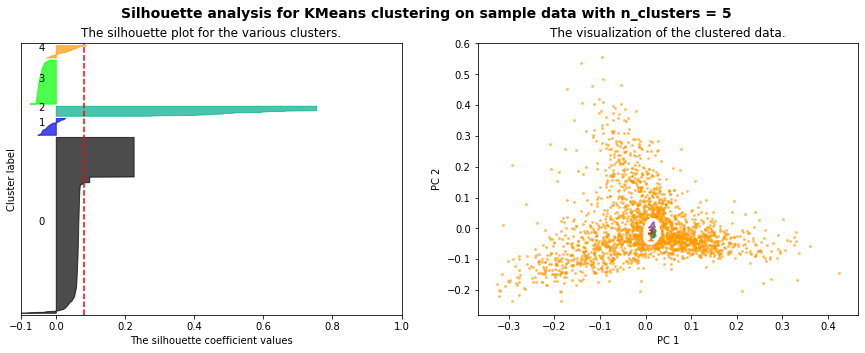

For n_clusters = 5, The average silhouette_score is : 0.082


In [57]:
#applying the plot sillhouette analysis
X = metooTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


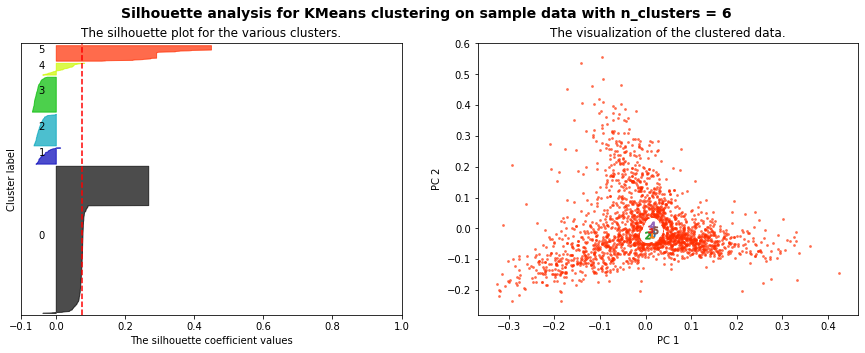

For n_clusters = 6, The average silhouette_score is : 0.076


In [58]:
X = metooTFVects.toarray() #when number of clusters is 6, silhouette score is the highest
plotSilhouette(6, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


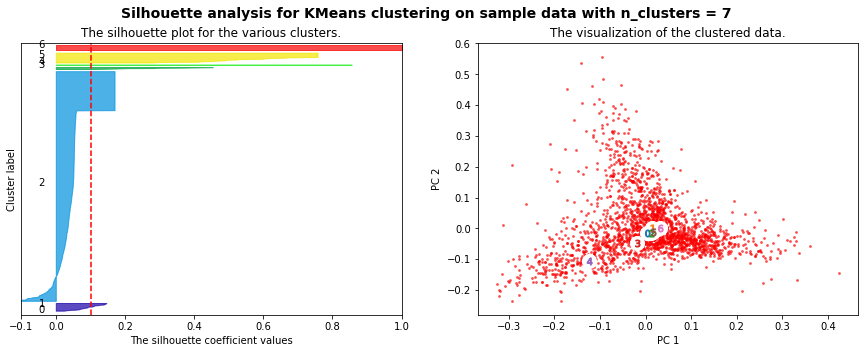

For n_clusters = 7, The average silhouette_score is : 0.102


In [59]:
X = metooTFVects.toarray()
plotSilhouette(7, X)

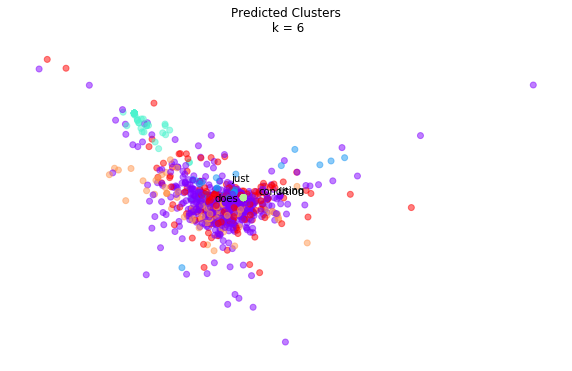

In [60]:
numCategories = 6  # since my dataset has no formal categories, for this example I'm setting it to 4

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(metooTFVects)


examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(metooTFVects.toarray())

components = examplePCA.components_
keyword_ids = list(set(order_centroids[:,4:5].flatten())) #Get the ids of some of the distinguishing words(features) from kmeans model, selecting these words that can actually stand out (other combinations are often two clustered together).
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()



In [61]:
#looking at distinguishing features in each cluster
numClusters = 6
terms = exampleTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = exampleKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 https
 com
 sexual
 www
 amp
 http
 timesup
 harassment
 just
 i_


Cluster 1:
 _ê
 __
 ___
 ê__ê
 ê_
 üê
 _____
 æê__ê
 ê__
 ____


Cluster 2:
 skeptic
 jury
 set
 hear
 closing
 weinstein
 harvey
 arguments
 news
 https


Cluster 3:
 webb
 foxx
 preckwinkle
 wins
 comey
 pulled
 says
 bernie
 office
 feminism


Cluster 4:
 la
 en
 el
 que
 qui
 des
 es
 le
 est
 https


Cluster 5:
 women
 movement
 men
 just
 com
 sexual
 think
 like
 https
 it_




In [62]:
numCategories = 6  
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(metooTFVects)

#adding k-means predictions to another column in the tweets dataframe
tweets_df['kmeans_predictions'] = exampleKM.labels_
tweets_df[:10]



,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,kmeans_predictions
0,2/13/20 18:25,acslaw,NaN,0,0,0,ACS has formed a #MeToo Task Force to combat s...,NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/acslaw/status/122802248369...,2
1,2/13/20 18:25,HealingFrTrauma,NaN,0,0,0,"Hey all, you know adult ADHD maybe a result of...",NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/HealingFrTrauma/status/122...,5
2,2/13/20 18:24,RvnsNest,NaN,0,0,0,"From 1996 to 1997, four women filed sexual-har...",NaN,@megangarber,#MeToo #MeToo,1.230000e+18,https://twitter.com/RvnsNest/status/1228022249...,5
3,2/13/20 18:23,film_pasco,brujasdelmar,0,0,0,#UNAM #FeminicidioEmergenciaNacional #Feminici...,NaN,NaN,#UNAM #FeminicidioEmergenciaNacional #Feminici...,1.230000e+18,https://twitter.com/film_pasco/status/12280219...,5
4,2/13/20 18:22,bernieshinder,davidaxelrod,0,0,0,We reacted (or didn_t react at all) to negat...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/bernieshinder/status/12280...,2
5,2/13/20 18:22,MediaCheck2016,Med4Pete,0,0,0,I_d do her is now a #metoo thing? How about ...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/MediaCheck2016/status/1228...,5
6,2/13/20 18:20,aimeliz318,NaN,0,0,1,"@Donnarotunno is lawyer goals! Damn, she is so...",NaN,@Donnarotunno,#MeToo #MeToo #HarveyWeinstein,1.230000e+18,https://twitter.com/aimeliz318/status/12280211...,5
7,2/13/20 18:19,bestdayever1616,NaN,1,1,0,Uh-Oh. Bloomie might want to reconsider things...,NaN,NaN,#METOO #METOO,1.230000e+18,https://twitter.com/bestdayever1616/status/122...,4
8,2/13/20 18:19,MediaCheck2016,jonathanchait,0,0,0,Hmmmmmm. Let me guess how many of us liberal g...,NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/MediaCheck2016/status/1228...,1
9,2/13/20 18:19,corydlg,NaN,0,0,0,"Which is fine, I_m sure she has her reasons....",NaN,NaN,#DontBeLastAugust #consentisntcomplicated #iho...,1.230000e+18,https://twitter.com/corydlg/status/12280207882...,5


From the results of the K-means clusters and silhouette analysis, it looks like the ultimate number of clusters is 6 (which has the highest silhouette score). Furthermore, one of the clusters (which is cluster 0) takes up the majority of the tweets as shown in visualizations. The centroid words displayed on visualizations are very close together, and from the coloring of the data points, the data of twitter texts appear to be very multi-dimensional. From the top words of each cluster, this cluster appears to be about the general sharing of #MeToo hashtags, websites, and activism, which is the content that most people associate with Metoo activism. Cluster 3 appears to be very small in number, but it is interestingly centered around sharing one particular headline that includes a metoo-related news and variety of celebrities and politicians that are not connected to metoo. Cluster 2 seems to be about the Harvey Weinstein case, and cluster 5 is potentially about gender-based backlash, and clusters 4 and 1 are foreign language tweets (with cluster 1 not beign able to show up due to the encoding set to Latin). 

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [63]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [64]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [65]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [66]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [67]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [68]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[143.        , 145.        ,   0.        ,   2.        ],
       [148.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [119.        , 154.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 112.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

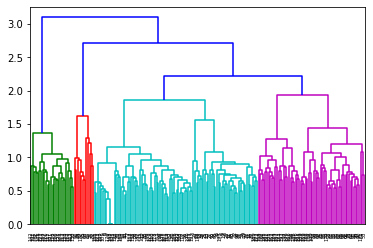

In [69]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

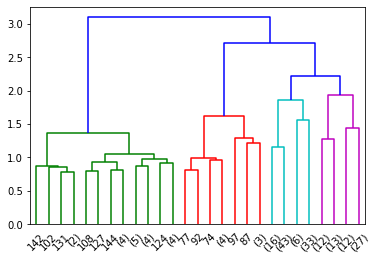

In [70]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [71]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [72]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [73]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [74]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

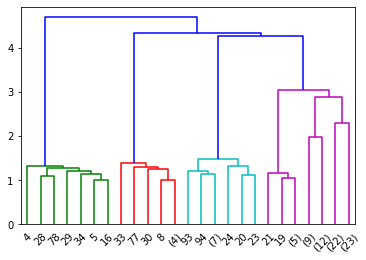

In [75]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [76]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [77]:
tweetsgroupsVects[:200].todense()  #looking at word occurence  matrix of similarity of documents

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [78]:
#first using ward hierarchical clustering on MeToo tweet documents
tweetsgroupsCoocMat = metooTFVects * metooTFVects.T
tweetsgroupsCoocMat.setdiag(0)
tweetslinkage_matrix = scipy.cluster.hierarchy.ward(tweetsgroupsCoocMat[:100, :100].toarray())
tweetslinkage_matrix_full = scipy.cluster.hierarchy.ward(tweetsgroupsCoocMat.toarray())
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(tweetslinkage_matrix, 6, 'maxclust')
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(tweetslinkage_matrix_full, 6, 'maxclust')



/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/wanxing/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [79]:
print(hierarchicalClusters_full)

[6 6 6 ... 6 4 6]


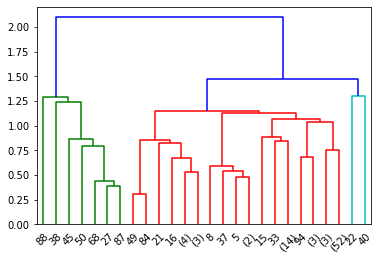

In [80]:
#100-tweet subset
ax = scipy.cluster.hierarchy.dendrogram(tweetslinkage_matrix, p=6, truncate_mode='level')


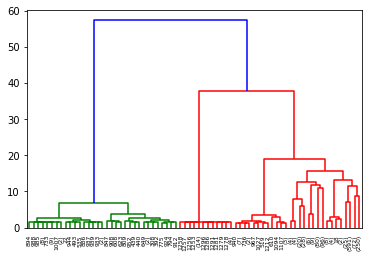

In [81]:
#hierarchical clustering of full set
ax = scipy.cluster.hierarchy.dendrogram(tweetslinkage_matrix_full, p=6, truncate_mode='level')


In [82]:
tweets_df['wald_predictions']= hierarchicalClusters_full
tweets_df[:20]

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,kmeans_predictions,wald_predictions
0,2/13/20 18:25,acslaw,NaN,0,0,0,ACS has formed a #MeToo Task Force to combat s...,NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/acslaw/status/122802248369...,2,6
1,2/13/20 18:25,HealingFrTrauma,NaN,0,0,0,"Hey all, you know adult ADHD maybe a result of...",NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/HealingFrTrauma/status/122...,5,6
2,2/13/20 18:24,RvnsNest,NaN,0,0,0,"From 1996 to 1997, four women filed sexual-har...",NaN,@megangarber,#MeToo #MeToo,1.230000e+18,https://twitter.com/RvnsNest/status/1228022249...,5,6
3,2/13/20 18:23,film_pasco,brujasdelmar,0,0,0,#UNAM #FeminicidioEmergenciaNacional #Feminici...,NaN,NaN,#UNAM #FeminicidioEmergenciaNacional #Feminici...,1.230000e+18,https://twitter.com/film_pasco/status/12280219...,5,6
4,2/13/20 18:22,bernieshinder,davidaxelrod,0,0,0,We reacted (or didn_t react at all) to negat...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/bernieshinder/status/12280...,2,6
5,2/13/20 18:22,MediaCheck2016,Med4Pete,0,0,0,I_d do her is now a #metoo thing? How about ...,NaN,NaN,#metoo #metoo,1.230000e+18,https://twitter.com/MediaCheck2016/status/1228...,5,6
6,2/13/20 18:20,aimeliz318,NaN,0,0,1,"@Donnarotunno is lawyer goals! Damn, she is so...",NaN,@Donnarotunno,#MeToo #MeToo #HarveyWeinstein,1.230000e+18,https://twitter.com/aimeliz318/status/12280211...,5,6
7,2/13/20 18:19,bestdayever1616,NaN,1,1,0,Uh-Oh. Bloomie might want to reconsider things...,NaN,NaN,#METOO #METOO,1.230000e+18,https://twitter.com/bestdayever1616/status/122...,4,4
8,2/13/20 18:19,MediaCheck2016,jonathanchait,0,0,0,Hmmmmmm. Let me guess how many of us liberal g...,NaN,NaN,#MeToo #MeToo,1.230000e+18,https://twitter.com/MediaCheck2016/status/1228...,1,6
9,2/13/20 18:19,corydlg,NaN,0,0,0,"Which is fine, I_m sure she has her reasons....",NaN,NaN,#DontBeLastAugust #consentisntcomplicated #iho...,1.230000e+18,https://twitter.com/corydlg/status/12280207882...,5,6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


ValueError: operands could not be broadcast together with shapes (6,4) (1000,) 

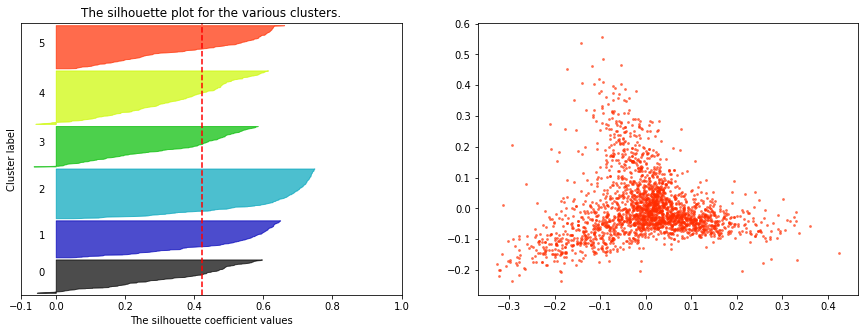

In [332]:
X = tweetslinkage_matrix_full  #attempting to use silhouette analysis for the ward hiearchical clustering results and appearing to get errors
plotSilhouette(6,X)

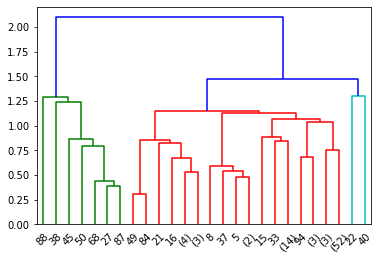

In [83]:
tweetslinkage_matrix = scipy.cluster.hierarchy.ward(tweetsgroupsCoocMat[:100, :100].toarray())
tweetslinkage_matrix_full = scipy.cluster.hierarchy.ward(tweetsgroupsCoocMat.toarray())

ax = scipy.cluster.hierarchy.dendrogram(tweetslinkage_matrix, p=6, truncate_mode='level')



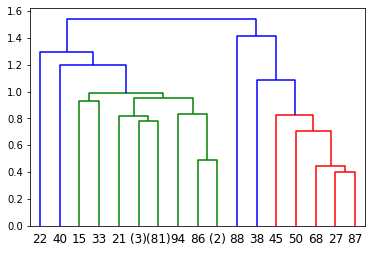

In [339]:
#using the complete linkage predictions
tweetslinkage_matrix_complete = scipy.cluster.hierarchy.complete(tweetsgroupsCoocMat[:100, :100].toarray())
tweetslinkage_matrix_full_complete  = scipy.cluster.hierarchy.complete(tweetsgroupsCoocMat.toarray())
hierarchicalClusters_complete = scipy.cluster.hierarchy.fcluster(tweetslinkage_matrix_complete, 6, 'maxclust')
hierarchicalClusters_full_complete = scipy.cluster.hierarchy.fcluster(tweetslinkage_matrix_full_complete, 6, 'maxclust')

ax = scipy.cluster.hierarchy.dendrogram(tweetslinkage_matrix_complete, p=6, truncate_mode='level')



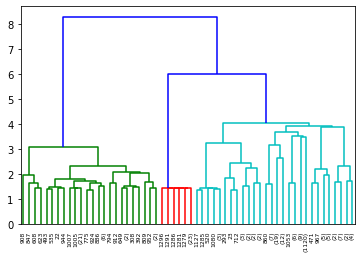

In [340]:
ax = scipy.cluster.hierarchy.dendrogram(tweetslinkage_matrix_full_complete, p=6, truncate_mode='level')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


ValueError: operands could not be broadcast together with shapes (6,4) (1000,) 

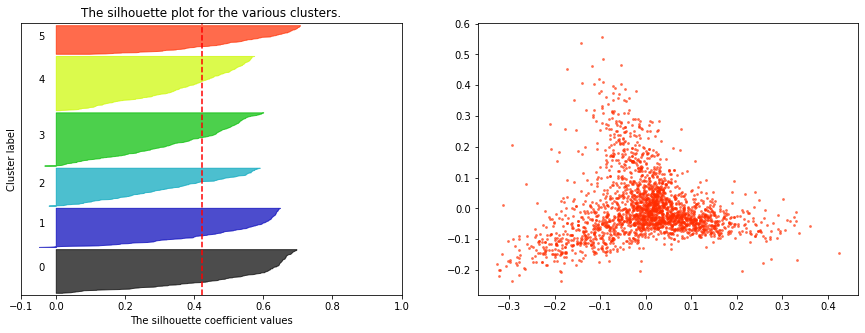

In [341]:
X = tweetslinkage_matrix_full_complete  #attempting to use silhouette analysis for the complete linkage hiearchical clustering results and appearing to get errors
plotSilhouette(6,X)

In [342]:
tweets_df['complete_linkage_predictions']= hierarchicalClusters_full_complete
tweets_df

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,kmeans_predictions,wald_predictions,tokenized_text,normalized_tokens,reduced_tokens,complete_linkage_predictions
0,2020-02-13 18:25:50,acslaw,NaN,0,0,0,ACS has formed a #MeToo Task Force to combat s...,NaN,NaN,#MeToo #MeToo,1228022483695132674,https://twitter.com/acslaw/status/122802248369...,0,3,"[ACS, has, formed, a, MeToo, Task, Force, to, ...","[acs, form, metoo, task, force, combat, sexual...","[form, task, combat, sexual, harassment, sexua...",4
1,2020-02-13 18:25:10,HealingFrTrauma,NaN,0,0,0,"Hey all, you know adult ADHD maybe a result of...",NaN,NaN,#MeToo #MeToo,1228022315046207488,https://twitter.com/HealingFrTrauma/status/122...,0,3,"[Hey, all, you, know, adult, ADHD, maybe, a, r...","[hey, know, adult, adhd, maybe, result, child,...","[adult, maybe, trauma, thought, model, explore...",4
2,2020-02-13 18:24:54,RvnsNest,NaN,0,0,0,"From 1996 to 1997, four women filed sexual-har...",NaN,@megangarber,#MeToo #MeToo,1228022249497800704,https://twitter.com/RvnsNest/status/1228022249...,0,5,"[From, 1996, to, 1997, four, women, filed, sex...","[woman, file, sexual, harassment, discriminati...","[woman, file, sexual, harassment, discriminati...",4
3,2020-02-13 18:23:39,film_pasco,brujasdelmar,0,0,0,#UNAM #FeminicidioEmergenciaNacional #Feminici...,NaN,NaN,#UNAM #FeminicidioEmergenciaNacional #Feminici...,1228021935436685313,https://twitter.com/film_pasco/status/12280219...,0,3,"[UNAM, FeminicidioEmergenciaNacional, Feminici...","[unam, feminicidioemergencianacional, feminici...",[],4
4,2020-02-13 18:22:40,bernieshinder,davidaxelrod,0,0,0,We reacted (or didn’t react at all) to negativ...,NaN,NaN,#metoo #metoo,1228021686911602696,https://twitter.com/bernieshinder/status/12280...,1,3,"[We, reacted, or, did, n’t, react, at, all, to...","[react, react, negative, political, advertise,...","[react, react, negative, advertise, trump, mov...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,2020-02-13 08:02:56,elZenakarGrande,NaN,2,1,63,کارمندای شرکت هیتاچی به جنبش #metoo پیوستن چون...,NaN,NaN,#metoo #metoo,1227865726083641346,https://twitter.com/elZenakarGrande/status/122...,0,3,"[کارمندای, شرکت, هیتاچی, به, جنبش, metoo, پیوس...","[کارمندای, شرکت, هیتاچی, به, جنبش, metoo, پیوس...",[],4
1296,2020-02-13 08:02:21,westcookreview,NaN,0,0,0,FOXX SAYS WEBB PULLED A COMEY — BERNIE WINS N....,NaN,NaN,#METOO #METOO,1227865581178818560,https://twitter.com/westcookreview/status/1227...,2,2,"[FOXX, SAYS, WEBB, PULLED, A, COMEY, BERNIE, W...","[foxx, say, webb, pull, comey, bernie, win, n....","[webb, pull, bernie, win]",2
1297,2020-02-13 08:02:19,Sabrina67408695,Josie80360617,0,0,0,#metoo,NaN,NaN,#metoo #metoo,1227865572681158658,https://twitter.com/Sabrina67408695/status/122...,0,3,[metoo],[metoo],[],4
1298,2020-02-13 08:01:45,WWRPodcast,NaN,0,3,0,"New Podcast! ""What's up with Harvey Weinstein...",NaN,@spreaker,#billcosby #epstein #freerkelly #ghislainemaxw...,1227865429164556288,https://twitter.com/WWRPodcast/status/12278654...,0,6,"[New, Podcast, What, 's, up, with, Harvey, Wei...","[new, podcast, harvey, weinstein, @spreaker, b...",[harvey],4


Both the wald and the complete linkage predictions suggest that there are various children clusters in the tweet dataset, with each children cluster having its own children clusters. The Wald hiearchical clustering predictions show that there is very large distance among the children clusters, the complete linkage clustering method shows less distance among the clusters possibly because it minimizes the maximum distance between each pair of clusters. The predictions from Wald and complete linkage methods seem to be similar, but there seems to be error in printing the silhouette visualization results, so it is hard to tell which one is more accurate. They are both quite different from k-means, which focuses on separating data into clusters with equal variance, whereas wald also uses aggolmerative clustering, and complete linkage focuses on minimizing distance between pairs of clusters.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [84]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [85]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [86]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [87]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [88]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [91]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [92]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [93]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(7, 0.9734697)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [94]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [95]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(4, 0.043697197), (6, 0.93093497)]",0.000000,0.000000,0.000000,0.000000,0.043697,0.000000,0.930935,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.25197673), (2, 0.74363744)]",0.000000,0.251977,0.743637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(1, 0.9976518)]",0.000000,0.997652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(0, 0.018511584), (1, 0.36987323), (6, 0.6100...",0.018512,0.369873,0.000000,0.000000,0.000000,0.000000,0.610009,0.000000,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(1, 0.6914732), (4, 0.10776114), (6, 0.195643)]",0.000000,0.691473,0.000000,0.000000,0.107761,0.000000,0.195643,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(0, 0.58474344), (9, 0.37570333)]",0.584743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375703
601,11Nov2005Kennedy6.txt,"[(1, 0.09806784), (3, 0.25793934), (6, 0.62247...",0.000000,0.098068,0.000000,0.257939,0.000000,0.000000,0.622475,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(1, 0.19154046), (8, 0.35744804), (9, 0.44878...",0.000000,0.191540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357448,0.448781
801,15Dec2005Kennedy5.txt,"[(1, 0.015935952), (5, 0.18886495), (7, 0.7938...",0.000000,0.015936,0.000000,0.000000,0.000000,0.188865,0.000000,0.793808,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(8, 0.9544219)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.954422,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [96]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.973470,0.000000,0.000000
1,0.000000,0.0,0.000000,0.0,0.043697,0.000000,0.930935,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.0,0.000000,0.531122,0.000000,0.000000,0.462686,0.000000
3,0.000000,0.0,0.980836,0.0,0.000000,0.000000,0.000000,0.000000,0.013911,0.000000
4,0.891841,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.106077,0.000000,0.000000
5,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.991333,0.000000,0.000000
6,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.989585
7,0.000000,0.0,0.967409,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.0,0.000000,0.0,0.000000,0.149120,0.000000,0.000000,0.846493,0.000000
9,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.078543,0.892760,0.000000


First we can visualize as a stacked bar chart:

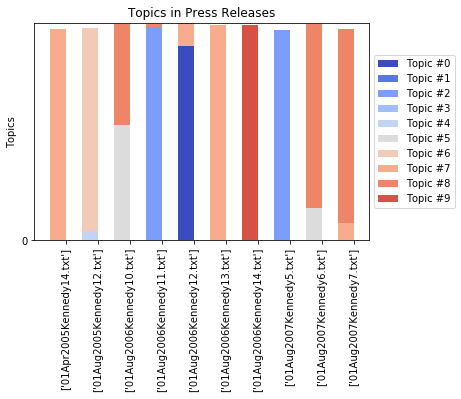

In [97]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

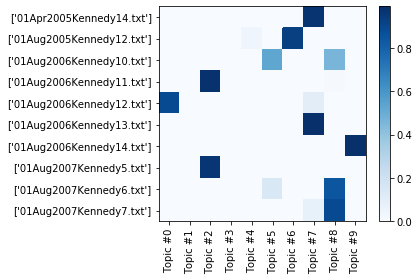

In [98]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [99]:
senlda.show_topic(1)

[('fund', 0.0146008255),
 ('asbestos', 0.0088348845),
 ('worker', 0.008120397),
 ('victim', 0.0062741064),
 ('trust', 0.004499336),
 ('cell', 0.004379092),
 ('science', 0.0041877325),
 ('stem', 0.004177065),
 ('wage', 0.004094962),
 ('disease', 0.004073644)]

And if we want to make a dataFrame:

In [100]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,worker,fund,teacher,worker,fund,worker,immigration,wage,loan,fund
1,pension,asbestos,insurance,troop,head,fund,worker,worker,lender,worker
2,company,worker,fund,medicare,agency,wage,immigrant,minimum,fund,head
3,fund,victim,medicare,coverage,worker,head,border,fund,head,judge
4,retirement,trust,wage,fund,attorney,lender,company,loan,unite,unite
5,wage,cell,loan,employee,company,loan,citizen,unite,woman,hear
6,employer,science,bankruptcy,insurance,fda,mental,unite,hour,aid,rule
7,employee,stem,base,company,troop,company,bankruptcy,pension,judge,immigration
8,standard,wage,rate,follow,judge,troop,intelligence,company,agency,stand
9,follow,disease,standard,attack,section,minimum,fund,tax,immigration,iraqi


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

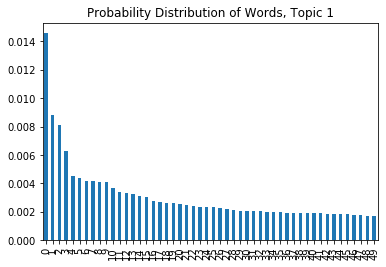

In [101]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [102]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

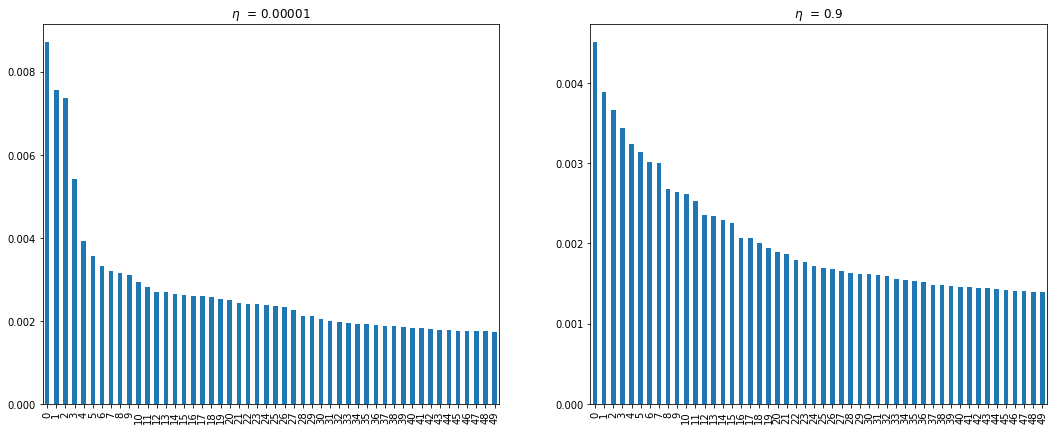

In [103]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [104]:
#applying tokenizations to the tweet texts
tweets_df['tokenized_text'] = tweets_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tweets_df['normalized_tokens'] = tweets_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

tweets_df['reduced_tokens'] = tweets_df['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))
#creating a dictionary and corpous
dictionary = gensim.corpora.Dictionary(tweets_df['reduced_tokens'])
corpus_tweet = [dictionary.doc2bow(text) for text in tweets_df['reduced_tokens']]
#serialization
gensim.corpora.MmCorpus.serialize('tweet.mm', corpus_tweet)
senmm = gensim.corpora.MmCorpus('tweet.mm')




In [105]:
#three different models, one automatic, one low alpha and low eta values, and another one high alpha and high eta values
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=6, alpha='auto', eta='auto')
senlda1  = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=6, alpha=0.2, eta=0.01)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=6, alpha=0.5, eta=0.9)

sen1Bow = dictionary.doc2bow(tweets_df['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
sen1lda1 = senlda1[sen1Bow]
sen1lda2 = senlda2[sen1Bow]
print("The topics of the text: {}".format(tweets_df['username'][0]))
print("are: {}".format(sen1lda))

The topics of the text: acslaw
are: [(2, 0.9545519)]


In [106]:

ldaDF = pandas.DataFrame({
        'name' : tweets_df['username'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in tweets_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]





,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
1,HealingFrTrauma,"[(0, 0.016407454), (1, 0.91955966), (2, 0.0156...",0.016407,0.919560,0.015673,0.015311,0.015511,0.017538
101,thatscratchyrat,"[(0, 0.078008436), (1, 0.07905404), (2, 0.0747...",0.078008,0.079054,0.074779,0.610470,0.073811,0.083877
201,StephenKoch16,"[(0, 0.16893767), (1, 0.17120199), (2, 0.16163...",0.168938,0.171202,0.161636,0.157944,0.159847,0.180433
301,Ne_co03,"[(0, 0.014722732), (1, 0.014929651), (2, 0.014...",0.014723,0.014930,0.014125,0.926529,0.013940,0.015754
401,bluntanddirect,"[(0, 0.07869096), (1, 0.07905403), (2, 0.07463...",0.078691,0.079054,0.074637,0.610491,0.073811,0.083316
501,Kbconn27Connors,"[(0, 0.16893767), (1, 0.17120199), (2, 0.16163...",0.168938,0.171202,0.161636,0.157944,0.159847,0.180433
601,Erty4444,"[(0, 0.01849032), (1, 0.018786099), (2, 0.9082...",0.018490,0.018786,0.908201,0.017277,0.017515,0.019730
701,CelebrityFind,"[(0, 0.16893767), (1, 0.17120199), (2, 0.16163...",0.168938,0.171202,0.161636,0.157944,0.159847,0.180433
801,PoetParagraph,"[(0, 0.010481403), (1, 0.0106401015), (2, 0.94...",0.010481,0.010640,0.947931,0.000000,0.000000,0.011216
901,biggeveen,"[(0, 0.16893767), (1, 0.17120199), (2, 0.16163...",0.168938,0.171202,0.161636,0.157944,0.159847,0.180433


In [107]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(6)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.000000,0.000000,0.954552,0.000000,0.000000,0.000000
1,0.016407,0.919560,0.015673,0.015311,0.015511,0.017538
2,0.000000,0.000000,0.000000,0.956990,0.000000,0.000000
3,0.168938,0.171202,0.161636,0.157944,0.159847,0.180433
4,0.021146,0.021428,0.020262,0.894528,0.020010,0.022626
5,0.078049,0.079099,0.074692,0.610314,0.073905,0.083942
6,0.029899,0.853250,0.028606,0.027943,0.028257,0.032044
7,0.037838,0.038077,0.035951,0.812335,0.035605,0.040193
8,0.018514,0.909259,0.017688,0.017258,0.017526,0.019755
9,0.024834,0.025203,0.876900,0.023145,0.023449,0.026469


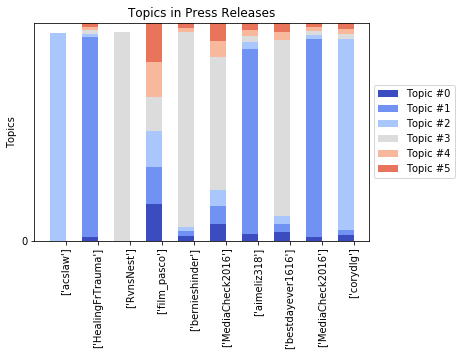

In [108]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 6))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()


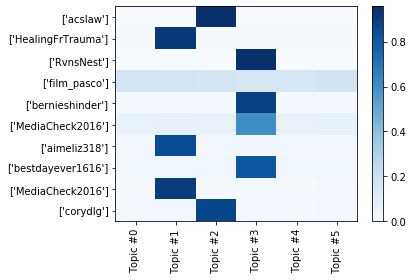

In [109]:
#heatmap
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [110]:
tweets_df['text'][:10]

0    ACS has formed a #MeToo Task Force to combat s...
1    Hey all, you know adult ADHD maybe a result of...
2    From 1996 to 1997, four women filed sexual-har...
3    #UNAM #FeminicidioEmergenciaNacional #Feminici...
4    We reacted (or didn_t react at all) to negat...
5    I_d do her is now a #metoo thing? How about ...
6    @Donnarotunno is lawyer goals! Damn, she is so...
7    Uh-Oh. Bloomie might want to reconsider things...
8    Hmmmmmm. Let me guess how many of us liberal g...
9    Which is fine, I_m sure she has her reasons....
Name: text, dtype: object

In [111]:
print(senlda.show_topic(1))
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

[('woman', 0.034372795), ('el', 0.018864388), ('man', 0.017709695), ('sexual', 0.01741855), ('bernie', 0.014518152), ('win', 0.013078404), ('pull', 0.0130778905), ('webb', 0.013070966), ('movement', 0.011036554), ('assault', 0.010849417)]


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,la,woman,woman,woman,woman,hear
1,man,el,sexual,movement,man,close
2,woman,man,movement,bloomberg,movement,jury
3,des,sexual,harassment,pull,sleep,woman
4,story,bernie,man,bernie,talk,la
5,es,win,die,win,abortion,movement
6,die,pull,victim,webb,love,harvey
7,tell,webb,think,mike,divide,argument
8,rape,movement,trump,stand,assault,sexual
9,el,assault,violence,man,victim,rape


<Figure size 432x288 with 0 Axes>

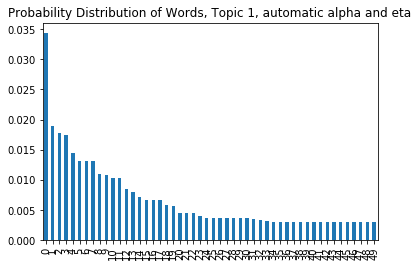

In [112]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1, automatic alpha and eta')
plt.show()

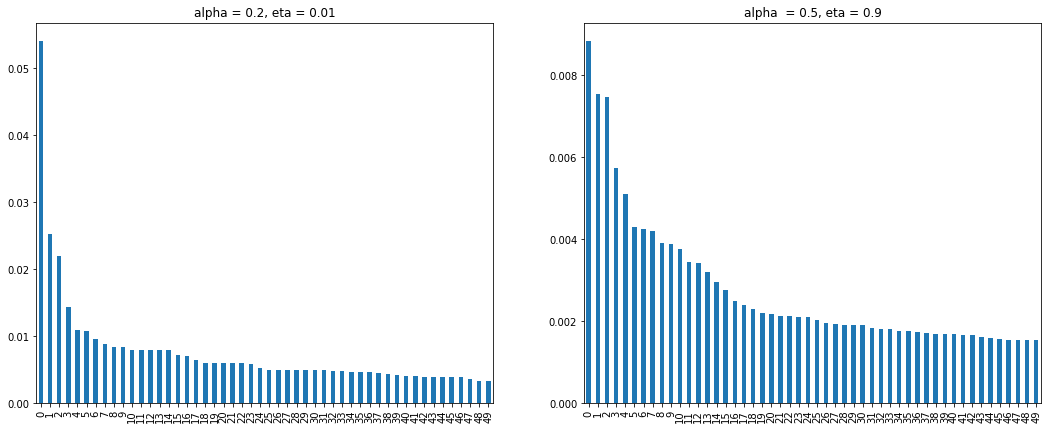

In [113]:

senlda1  = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=6, alpha=0.2, eta=0.01)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=6, alpha=0.5, eta=0.9)


topic21_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic31_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(18, 7)
topic21_df.plot.bar(legend = False, ax = ax1, title = 'alpha = 0.2, eta = 0.01')
topic31_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.5, eta = 0.9')
plt.show()

In [114]:
#using the first model with alpha =0.2, eta = 0.01
sen1lda1 = senlda1[sen1Bow]
ldaDF = pandas.DataFrame({
        'name' : tweets_df['username'],
        'topics' : [senlda1[dictionary.doc2bow(l)] for l in tweets_df['reduced_tokens']]
    })

topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda1.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda1.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
1,HealingFrTrauma,"[(0, 0.88945365), (1, 0.022272388), (2, 0.0223...",0.889454,0.022272,0.022319,0.021790,0.021845,0.022319
101,thatscratchyrat,"[(0, 0.09091376), (1, 0.09091376), (2, 0.09183...",0.090914,0.090914,0.091834,0.091411,0.544014,0.090914
201,StephenKoch16,"[(0, 0.16666666), (1, 0.16666666), (2, 0.16666...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
301,Ne_co03,"[(0, 0.019800577), (1, 0.89964515), (2, 0.0205...",0.019801,0.899645,0.020544,0.019932,0.020015,0.020064
401,bluntanddirect,"[(0, 0.09433674), (1, 0.54037297), (2, 0.09091...",0.094337,0.540373,0.090917,0.090917,0.090917,0.092540
501,Kbconn27Connors,"[(0, 0.16666666), (1, 0.16666666), (2, 0.16666...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
601,Erty4444,"[(0, 0.024494702), (1, 0.8760294), (2, 0.02479...",0.024495,0.876029,0.024799,0.024871,0.025081,0.024725
701,CelebrityFind,"[(0, 0.16666666), (1, 0.16666666), (2, 0.16666...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
801,PoetParagraph,"[(0, 0.014293668), (1, 0.32540697), (2, 0.0143...",0.014294,0.325407,0.014357,0.617292,0.014412,0.014239
901,biggeveen,"[(0, 0.16666666), (1, 0.16666666), (2, 0.16666...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [115]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(6)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.012555,0.012658,0.937263,0.012493,0.012543,0.012488
1,0.889454,0.022272,0.022319,0.021790,0.021845,0.022319
2,0.011948,0.412079,0.540541,0.011807,0.011897,0.011729
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.028054,0.028115,0.859639,0.027957,0.028388,0.027847
5,0.091399,0.091676,0.091475,0.540474,0.092358,0.092618
6,0.038542,0.038656,0.038596,0.038533,0.807184,0.038488
7,0.047692,0.047730,0.047702,0.761208,0.047820,0.047848
8,0.024513,0.024630,0.024442,0.024653,0.877056,0.024706
9,0.033996,0.032918,0.032392,0.032951,0.835399,0.032344


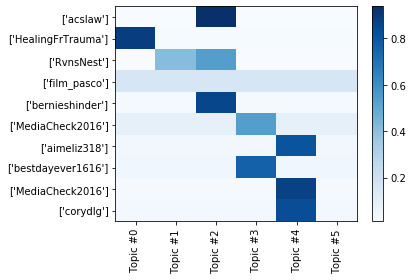

In [116]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [344]:
topicsDict = {}
for topicNum in range(senlda1.num_topics):
    topicWords = [w for w, p in senlda1.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,man,woman,woman,la,win,hear
1,el,movement,man,les,webb,movement
2,woman,man,la,es,bernie,rape
3,die,hear,read,woman,pull,la
4,happen,close,hear,sexual,sexual,close
5,film,sexual,se,victim,harassment,trial
6,victim,jury,close,story,woman,victim
7,accuse,think,sexual,el,love,jury
8,story,rape,jury,et,man,woman
9,dark,harassment,survivor,die,movement,et


With the topic model of automatic alpha and eta values, the visualizations suggest that while each tweet shown is mainly dominated by one topic, there are also tweets with even distribution of several topics. The probability distribution of top words would start with one word with very high frequency and then drop, then the word probabilities for the other top words would decrease more gradually. One topic (topics 1 and 3) contains quite a few words that appear to be from a headline containing #MeToo news with some other political news, and topic 5 being about Harvey Weinstein's case. Several topics also contain foreign langauge words such as "la" and "es". I then changed the alpha and eta values, with one having lower alpha and eta values, and another model having higher alpha and eta values. Then mode lwith lower alpha and eta values produced a word probability distribution that is much more sharply right-skewed, which I took to be indicative of a better model than the model with auotmatic alpha and eta values. The visualization heatmap also looked quite close to the model with automatic alpha and eta values. For the topic model dataframe, while words associated with the Harvey Weinstein case now had become seen in more topics, the words associated with the #MeToo headline is now concentrated in just one topic (topic 4).

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [118]:
corpora_address = "/Users/wanxing/Downloads/Corpora/SOAP"

In [119]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [120]:
import zipfile
import pandas as pd

In [121]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [122]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [123]:
soap_dict = {}

In [124]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [125]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [126]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [127]:
i = 0

In [128]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [129]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Checking to see which index I should use. In my example it is the first one, so I choose my index as 0. It might be different for you!

In [130]:
dool = soap_df['Tokenized Texts'][0]

In [131]:
' '.join(dool[0:1500])

"@!Liza You 're in early @!Ryan Yeah I had stuff to do I did n't expect to see you here either @!Liza I could n't sleep Want to tell me why you 're packing up your desk @!Ryan Oh I 'm leaving Liza This this was a mistake @!Liza Well that 's constructive @!Ryan Well there 's no reason for me to be here I mean I can get a job anywhere And since that 's the case I mean there 's no reason for me to be in this town too so I 'm just @!Liza So now you 're leaving your job and you 're leaving town @!Ryan Yes @!Liza Not one reason to stay nothing @!Ryan That 's right @!Liza One question @!Ryan What 's that @!Liza What about me @!Ryan Liza you can get a dozen guys to sell ad time like I do @!Liza I do n't really give a damn about the job What I said was what about a lot of things @!Gillian Well I do n't want to hear about it Just leave me alone @!Jesse Whoa whoa whoa Just settle down there little Miss Drama Queen I 'm just trying to tell you that you did the right thing last night at the Turret 

In [132]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [133]:
import networkx as nx

In [134]:
actor_network = nx.Graph()

In [135]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [136]:
i = 0

In [137]:
all_texts = []

In [138]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

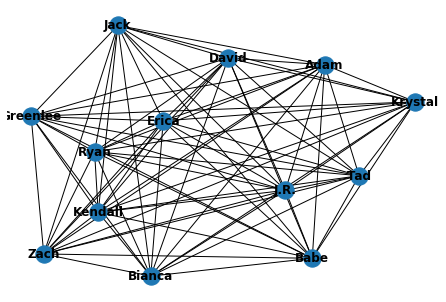

In [139]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [140]:
all_texts[0:10]

[['yes', 'stuff', 'expect'],
 ['oh', 'be', 'leave', 'liza', 'mistake'],
 ['reason', 'mean', 'job', 'case', 'mean', 'reason', 'town', 'be'],
 ['yes'],
 ['right'],
 [],
 ['liza', 'dozen', 'guy', 'sell', 'ad', 'time', 'like'],
 ['oh', 'hello'],
 ['sleep'],
 ['fab', 'listen', 'jake', 'night']]

In [141]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [142]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [145]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [146]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [147]:
doollda.show_topics()

[(0,
  '0.044*"zach" + 0.040*"like" + 0.031*"say" + 0.026*"home" + 0.024*"man" + 0.019*"uh" + 0.017*"lose" + 0.016*"remember" + 0.015*"huh" + 0.015*"worry"'),
 (1,
  '0.180*"yes" + 0.102*"oh" + 0.052*"have" + 0.036*"get" + 0.024*"let" + 0.022*"god" + 0.022*"idea" + 0.019*"way" + 0.015*"good" + 0.012*"watch"'),
 (2,
  '0.049*"come" + 0.048*"greenlee" + 0.042*"david" + 0.033*"leave" + 0.033*"maybe" + 0.031*"wait" + 0.031*"mean" + 0.023*"actually" + 0.021*"jack" + 0.020*"run"'),
 (3,
  '0.185*"be" + 0.138*"okay" + 0.039*"hey" + 0.037*"sure" + 0.034*"sorry" + 0.026*"go" + 0.025*"na" + 0.025*"gon" + 0.014*"know" + 0.013*"minute"'),
 (4,
  '0.095*"tell" + 0.048*"try" + 0.046*"happen" + 0.029*"j.r" + 0.024*"go" + 0.023*"work" + 0.023*"ask" + 0.023*"know" + 0.021*"find" + 0.019*"family"'),
 (5,
  '0.125*"know" + 0.030*"well" + 0.026*"thing" + 0.021*"wrong" + 0.020*"have" + 0.019*"hmm" + 0.017*"love" + 0.016*"kind" + 0.016*"time" + 0.016*"course"'),
 (6,
  '0.135*"right" + 0.056*"need" + 0.044*

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [148]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [149]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(1, 0.111938365), (2, 0.2430715), (3, 0.031526733), (7, 0.3745733), (8, 0.23777148)]
[(1, 0.12189783), (2, 0.24303137), (3, 0.036043108), (7, 0.3695147), (8, 0.22775516)]
[(1, 0.12155366), (2, 0.24012448), (3, 0.036099885), (7, 0.37691513), (8, 0.22335972)]
[(1, 0.112447314), (2, 0.25159398), (3, 0.0327705), (7, 0.3660443), (8, 0.23411089)]
[(1, 0.11529708), (2, 0.24778867), (3, 0.03706775), (7, 0.36925107), (8, 0.22809091)]
[(1, 0.11468737), (2, 0.24292804), (3, 0.03478299), (7, 0.37188804), (8, 0.2332885)]
[(1, 0.114358544), (2, 0.24325703), (3, 0.04212966), (7, 0.36913988), (8, 0.22960004)]
[(1, 0.11505139), (2, 0.2406867), (3, 0.0301838), (7, 0.379658), (8, 0.23302531)]
[(1, 0.11256383), (2, 0.25077742), (3, 0.03887459), (7, 0.36218995), (8, 0.23426776)]
[(1, 0.11408881), (2, 0.24504252), (3, 0.038823433), (7, 0.3745789), (8, 0.22610709)]
[(1, 0.11297525), (2, 0.24589166), (3, 0.04240769), (7, 0.36368358), (8, 0.23396596)]
[(1, 0.11791967), (2, 0.25959292), (3, 0.033367164), (7, 0

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [150]:
from gensim.matutils import kullback_leibler

In [151]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [152]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

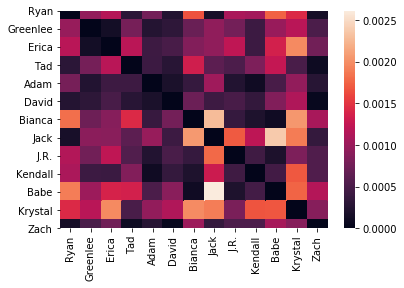

In [153]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [154]:
corpora_address = "/Users/wanxing/Downloads/Corpora/COHA"

In [155]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [156]:
list(coha_texts.keys())[0:5]

['mag_1815_552651.txt',
 'mag_1816_552727.txt',
 'mag_1816_552728.txt',
 'mag_1816_552807.txt',
 'mag_1816_552808.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [157]:
coha_genres = {}
coha_years = {}

In [158]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [159]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [160]:
coha_years.keys()

dict_keys(['1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [161]:
import collections

In [162]:
years = []
year_lens = []

In [163]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [164]:
years[0], years[-1]

('1810', '2009')

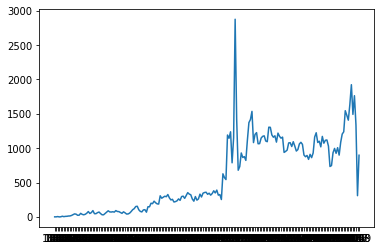

In [165]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: their are far less articles in the beginning, and then it grows. Maybe in our 4 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [168]:
all_texts_coha = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [170]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1


#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size.

In [302]:
def choose_n(corpus, time_slices, nums=1000):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [303]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)
final_corpus= []
docs_per_time_slice = [0, 0, 0, 0, 0]

In [304]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [305]:
dictionary = gensim.corpora.Dictionary(final_corpus)
corpus = [dictionary.doc2bow(text) for text in final_corpus]
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [306]:
from gensim.models import ldaseqmodel

In [307]:
#ldaseq = ldaseqmodel.LdaSeqModel(corpus=small_corpus, id2word=dictionary, time_slice=docs_per_year, num_topics=4)

In [ ]:
#ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)


/Users/wanxing/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
#ldaseq.print_topics(time=0)[1]

In [ ]:
#ldaseq.print_topics(time=1)

In [317]:
#ldaseq.save("ldaseqmodel")
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

In [378]:
loaded_model.print_topics(time=0)[1]

[('state', 0.010467405349664085),
 ('government', 0.005099042458318125),
 ('country', 0.0043322875124255904),
 ('great', 0.00429728994665638),
 ('power', 0.004221705947522456),
 ('new', 0.004132381407050644),
 ('man', 0.0040447585182303404),
 ('say', 0.003912174428614769),
 ('time', 0.0038870896287730135),
 ('people', 0.0036404887064150787),
 ('general', 0.0028888173218918852),
 ('year', 0.0028774881788032583),
 ('find', 0.0028215549896175723),
 ('unite', 0.002802638436547223),
 ('river', 0.002745321679186511),
 ('place', 0.0025117230163612496),
 ('mile', 0.0024649861621410655),
 ('public', 0.002431310419443392),
 ('day', 0.0023945224073290902),
 ('law', 0.0023714174191687624)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [346]:
#selecting the "As the World Turns" text in the Soap dataset since my own dataset doesn't work well
dool_1 = soap_df['Tokenized Texts'][1]
' '.join(dool_1[0:3000])

"@!Katie Simon where are you @!Simon Katie @!Katie You 're in my dream @!Simon No I 'm on your damn beach If you do anything like this again I 'm gon na leave you here Katie drops a coconut on Simon 's foot Ow @Ow ow @!Katie Oh Simon I 'm sorry I 'm so so sorry @!Simon Do n't do n't touch me @!Katie Is your foot okay @!Simon Yes it 's fine Leave me alone Ow @!Katie You found me @!Simon Yes yes I found you What do you think I 'm going to do just leave you here Wake up @!Jack Ca n't find record of payment Past due past due Past due past due Carly You 're up early Sorry Carly goes into the kitchen and brings out an empty coffee pot Hey Did you drink all this @!Jack Yeah Sorry @!Carly No no that 's it 's okay you might not sleep for a week Hey it 's going to be okay Jack We can always use the Carly Tenney system @!Jack Rob a bank @!Carly No that 's Plan B Plan A you just throw all the bills up in the air and whatever stays up there well that deserves to get paid @!Jack With what I gave her

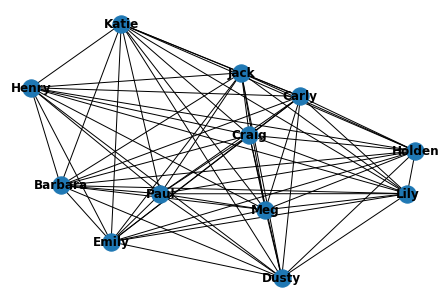

In [380]:
characters = {}
for token in dool_1:
    if token[0] == '@':
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

actor_network = nx.Graph()

for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
        
        
i = 0 
all_texts = []
for token in dool_1:
    i += 1
    if i > len(dool_1):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool_1[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool_1[i:j]))
          
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [385]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool_1.mm', corpus)
doolcorpus_1 = gensim.corpora.MmCorpus('dool_1.mm')
doollda_1 = gensim.models.ldamodel.LdaModel(corpus=doolcorpus_1, id2word=dictionary, num_topics=8, alpha='auto', eta='auto')
doollda_1.show_topics()



[(0,
  '0.047*"think" + 0.038*"mean" + 0.030*"leave" + 0.028*"fine" + 0.026*"holden" + 0.023*"lily" + 0.023*"hear" + 0.022*"stop" + 0.017*"be" + 0.015*"parker"'),
 (1,
  '0.135*"okay" + 0.053*"thank" + 0.041*"talk" + 0.040*"good" + 0.025*"hello" + 0.025*"well" + 0.023*"right" + 0.021*"be" + 0.019*"great" + 0.017*"believe"'),
 (2,
  '0.107*"know" + 0.052*"right" + 0.042*"like" + 0.028*"think" + 0.022*"feel" + 0.021*"henry" + 0.020*"wait" + 0.020*"thing" + 0.014*"maybe" + 0.014*"god"'),
 (3,
  '0.098*"be" + 0.081*"need" + 0.046*"sorry" + 0.033*"get" + 0.022*"uh" + 0.021*"know" + 0.020*"try" + 0.020*"damian" + 0.016*"mother" + 0.015*"ask"'),
 (4,
  '0.063*"tell" + 0.033*"craig" + 0.031*"love" + 0.022*"baby" + 0.020*"find" + 0.019*"know" + 0.016*"go" + 0.016*"think" + 0.014*"try" + 0.014*"paul"'),
 (5,
  '0.104*"want" + 0.056*"come" + 0.034*"let" + 0.022*"wrong" + 0.020*"know" + 0.020*"think" + 0.017*"say" + 0.017*"help" + 0.016*"way" + 0.015*"right"'),
 (6,
  '0.081*"na" + 0.081*"gon" + 0

In [383]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda_1[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.16597323), (1, 0.036054283), (2, 0.024297537), (4, 0.32024294), (5, 0.082051575), (6, 0.1564755), (7, 0.21490401)]
[(0, 0.16765538), (1, 0.036290318), (2, 0.023764284), (4, 0.3182166), (5, 0.080965444), (6, 0.15681753), (7, 0.21628968)]
[(0, 0.16825207), (1, 0.035346713), (2, 0.024641803), (4, 0.3162715), (5, 0.08194419), (6, 0.15276952), (7, 0.2207735)]
[(0, 0.16767357), (1, 0.035836115), (2, 0.02395689), (4, 0.31764218), (5, 0.08300301), (6, 0.15457588), (7, 0.21731095)]
[(0, 0.1677972), (1, 0.035738446), (2, 0.023902567), (4, 0.31722373), (5, 0.08236604), (6, 0.15601256), (7, 0.21695857)]
[(0, 0.16604692), (1, 0.035700675), (2, 0.02515056), (4, 0.31676504), (5, 0.0841353), (6, 0.15412644), (7, 0.21807353)]
[(0, 0.1666119), (1, 0.036120705), (2, 0.025296539), (4, 0.31677276), (5, 0.083322436), (6, 0.1532032), (7, 0.21867163)]
[(0, 0.16604614), (1, 0.036028966), (2, 0.025610937), (4, 0.3172296), (5, 0.08212984), (6, 0.15695386), (7, 0.21599942)]
[(0, 0.16664082), (1, 0.03685306

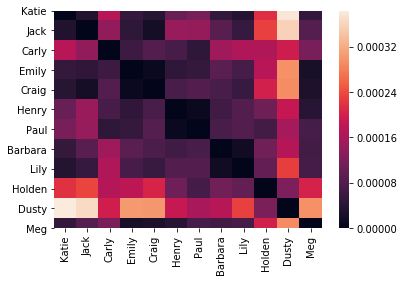

In [384]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()